In [1]:
import os
import re

import pandas as pd
import numpy as np

import nlp
import gensim
import nltk
from nltk.corpus import stopwords 
import nltk
from nltk import tokenize
from nltk.tokenize import TweetTokenizer

from nltk.sentiment import SentimentIntensityAnalyzer

from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import spacy

from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter, OrderedDict
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

from itertools import compress
import collections
from collections import Counter

from gensim.models.word2vec import Word2Vec
from nltk.tokenize import word_tokenize
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import seaborn as sns
import matplotlib.ticker as mticker

# Preprocessing

In [2]:
# import data as dataframe
data = pd.read_excel("cleaned_all.xlsx")

In [3]:
data['Sound Bite Text'].astype(str)
data['text']=data['Sound Bite Text'].str.lower()
data.dropna(subset=['Sound Bite Text'], inplace=True)
data['text'] = data['text'].astype('string')
data['text_split']=data['text'].str.split()
data = data.dropna(subset=['Sound Bite Text'])
data = data[data['Sound Bite Text']!='nan']
data.dropna(subset=['text_split'], inplace=True)

### Filter Reviews that is related to Apple

In [4]:
getApple = ['iphone','x', '8']

def filter_apple(splitlist):
    nltk=[]
    for i in splitlist:
        if i in getApple:
            nltk.append(i)
    return list(set(nltk))
data['apple_tag'] = data['text_split'].apply(filter_apple)

### Filter Reviews that is related to Samsung

In [5]:
getSamsung = ['galaxy','s8', 'samsung']

def filter_samsung(splitlist):
    nltk=[]
    for i in splitlist:
        if i in getSamsung:
            nltk.append(i)
    return list(set(nltk))
data['samsung_tag'] = data['text_split'].apply(filter_samsung)

In [6]:
data['samsung'] = data['samsung_tag'].apply(lambda s: 1 if len(s) != 0 else 0)
data['apple'] = data['apple_tag'].apply(lambda s: 1 if len(s) != 0 else 0)

In [7]:
data['both'] = data['samsung']+data['apple']
data = data.drop('samsung_tag',1)
data = data.drop('apple_tag',1)

/var/folders/vg/pr1vdfbs7xj4xh3qmndt97m40000gn/T/ipykernel_27306/1877862849.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data = data.drop('samsung_tag',1)
/var/folders/vg/pr1vdfbs7xj4xh3qmndt97m40000gn/T/ipykernel_27306/1877862849.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data = data.drop('apple_tag',1)


### Remove stopwords and irrelevant words

In [9]:
# function to remove stop words
tknzr = TweetTokenizer()
nlp = spacy.load("en_core_web_sm")

useless=['iphone','iphone8','iphonex','apple','new','galaxy','samsung','device','devices','phone','mobile','flagship',
         'news','company','user','users','flag']

def remove_stop_words(string):
    cleaned=[word for word in tknzr.tokenize(string.lower()) if word not in useless and word not in nlp.Defaults.stop_words and len(word)>2]
    cleaned_str = ' '.join(cleaned)   
    return cleaned_str

In [10]:
# function to remove URL
def delete_URL(data):
    #Removing URLs with a regular expression
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    data = url_pattern.sub(r'', data)
    
    data=re.sub(r'/.*', "", data)

    # Remove Emails
    data = re.sub('\S*@\S*\s?', '', data)

    # Remove new line characters
    data = re.sub('\s+', ' ', data)

    # Remove distracting single quotes
    data = re.sub("\'", "", data)
    
    #.com pattern
    data = re.sub(r'[A-Za-z]*.com$', "", data)
    
    # tag pattern
    tag_pattern = re.compile(r'#([a-zA-Z0-9_]{1,50})')
    data = tag_pattern.sub(r'', data)

    return data

# Generate data with only Samsung related reviews

In [11]:
samsung = data[(data['samsung'] == 1) & (data['apple'] != 1)]

In [12]:
samsung.loc[:,'Sound Bite Text'] = samsung.loc[:,'Sound Bite Text'].apply(delete_URL).copy()
samsung.loc[:,'Sound Bite Text'] = samsung.loc[:,'Sound Bite Text'].apply(remove_stop_words).copy()

/Users/jingyiran/opt/anaconda3/envs/yiyi/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


# Sentiment Analysis of Samsung product

### TextBlob

In [13]:
# texblob- samsung
samsung.loc[:,'sentiment score'] = samsung.loc[:,'Sound Bite Text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity).copy()
samsung.loc[:,"sentiment"] = np.select([samsung.loc[:,"sentiment score"] < 0, 
                                        samsung.loc[:,"sentiment score"] == 0, 
                                        samsung.loc[:,"sentiment score"] > 0],['neg', 'neu', 'pos']).copy()

/Users/jingyiran/opt/anaconda3/envs/yiyi/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


<AxesSubplot:xlabel='sentiment'>

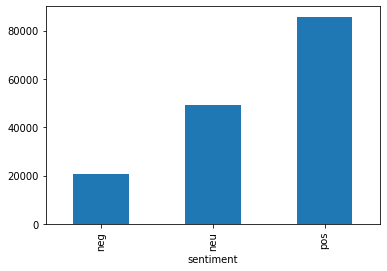

In [14]:
# based on textblob-samsung
samsung.groupby('sentiment')['Post ID'].count().plot(kind ='bar')

### Vader

In [15]:
# vader on samsung
import operator
sia = SentimentIntensityAnalyzer()
samsung.loc[:,"sentiment_score_2"] = samsung.loc[:,'Sound Bite Text'].apply(lambda x: sia.polarity_scores(x)["compound"]).copy()
samsung.loc[:,"sentiment_2"] = np.select([samsung.loc[:,"sentiment_score_2"] < 0, 
                                          samsung.loc[:,"sentiment_score_2"] == 0, 
                                          samsung.loc[:,"sentiment_score_2"] > 0],['neg', 'neu', 'pos']).copy()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/jingyiran/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
/Users/jingyiran/opt/anaconda3/envs/yiyi/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


<AxesSubplot:xlabel='sentiment_2'>

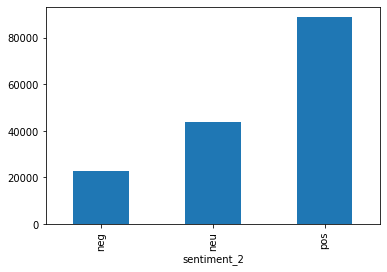

In [16]:
# based on vader-samsung
samsung.groupby('sentiment_2')['Post ID'].count().plot(kind ='bar')

### Generate both positive and negative reviews for further analysis

In [17]:
samsung_neg = samsung.groupby('sentiment').get_group('neg')

In [18]:
samsung_pos = samsung.groupby('sentiment').get_group('pos')

#### Common attributes for Negative sentiment of Samsung

In [20]:
neg_samsung_tweets = samsung_neg['Sound Bite Text']

In [21]:
useless2 = ['smartphone', 'phone', 'mobile', 'phones','smartphones','irrelevant']

In [22]:
s_neg_str = ''.join(neg_samsung_tweets)

In [23]:
cleaned_s_neg=[word for word in tknzr.tokenize(s_neg_str.lower()) if word not in useless2 and len(word)>2]
cleaned_s_neg_str = ' '.join(cleaned_s_neg)   

# Top Attributes of negative reviews of Samsung

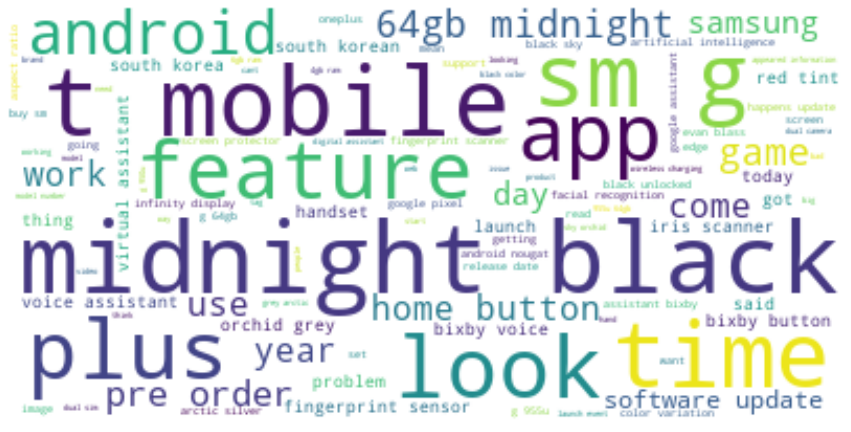

In [24]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Use wordcloud to visualize the words with frequency
wordcloud_s_neg = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(cleaned_s_neg_str)
plt.figure(figsize=(15,12))
plt.imshow(wordcloud_s_neg, interpolation='bilinear')
plt.axis("off")
plt.show()

# Reference: Datacamp
# https://www.datacamp.com/community/tutorials/wordcloud-python

### Generate Top 40 attributes

In [25]:
s_neg_adjs = []
s_neg_nouns = []
s_neg_overall = []

s_neg_adj_counter = Counter(s_neg_adjs)
s_neg_noun_counter = Counter(s_neg_nouns)
s_neg_overall_counter = Counter(s_neg_overall)

for tw in neg_samsung_tweets:
    for token in nlp(tw.lower()):
        if len(token.text) > 2:
            s_neg_overall.append(token.text)
        if token.pos_ == 'ADJ' and len(token.text) > 2:
            s_neg_adjs.append(token.text)
        elif token.pos_ == 'NOUN' and len(token.text) > 2:
            s_neg_nouns.append(token.text)

In [26]:
s_neg_adj_counter.update(s_neg_adjs)
s_neg_noun_counter.update(s_neg_nouns)
s_neg_overall_counter.update(s_neg_overall)

In [27]:
common_s_neg_adj=pd.DataFrame(s_neg_adj_counter.most_common()[:40])
common_s_neg_adj.columns=['word','count']

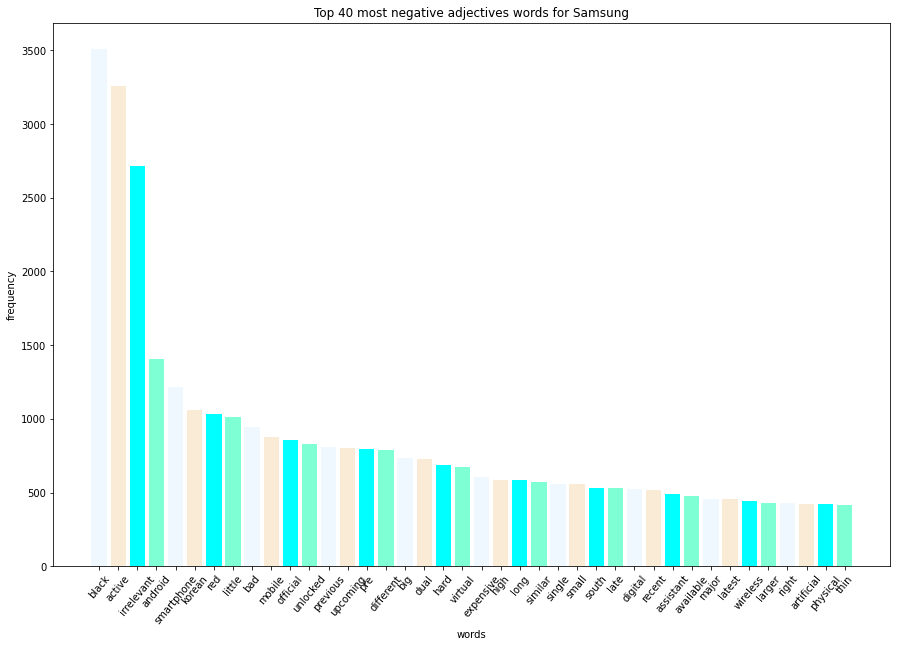

In [28]:
plt.figure(figsize=(15,10))
color_backup = ['aliceblue','antiquewhite','aqua','aquamarine'] 
plt.bar(common_s_neg_adj['word'],common_s_neg_adj['count'],color=color_backup)
plt.xticks(rotation=50)
plt.xlabel("words")
plt.ylabel("frequency")
plt.title('Top 40 most negative adjectives words for Samsung')
plt.show()

# Top Attributes of positive reviews of Samsung

In [29]:
pos_samsung_tweets = samsung_pos['Sound Bite Text']

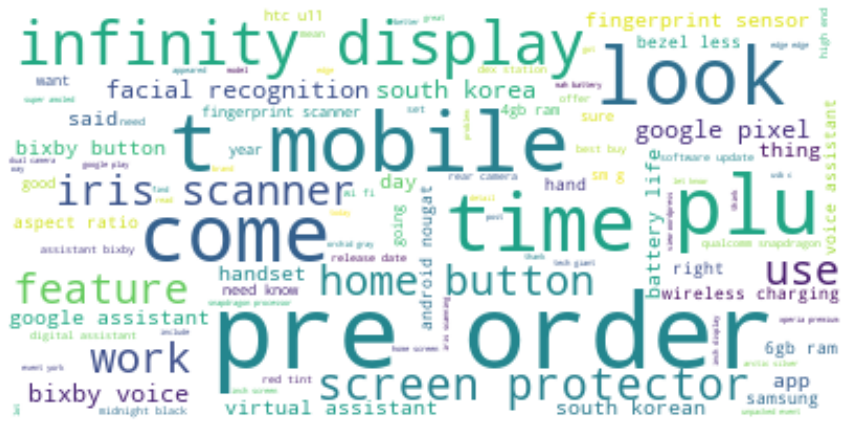

In [30]:
s_pos_str = ''.join(pos_samsung_tweets)
cleaned_s_pos=[word for word in tknzr.tokenize(s_pos_str.lower()) if word not in useless2 and len(word)>2]
cleaned_s_pos_str = ' '.join(cleaned_s_pos)  

# Use wordcloud to visualize the words with frequency
wordcloud_s_pos = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(cleaned_s_pos_str)
plt.figure(figsize=(15,12))
plt.imshow(wordcloud_s_pos, interpolation='bilinear')
plt.axis("off")
plt.show()

### Generate Top 40 attributes

In [31]:
s_pos_adjs = []
s_pos_nouns = []
s_pos_overall = []

s_pos_adj_counter = Counter(s_pos_adjs)
s_pos_noun_counter = Counter(s_pos_nouns)
s_pos_overall_counter = Counter(s_pos_overall)

for tw in pos_samsung_tweets:
    for token in nlp(tw.lower()):
        if len(token.text) > 2:
            s_pos_overall.append(token.text)
        if token.pos_ == 'ADJ' and len(token.text) > 2:
            s_pos_adjs.append(token.text)
        elif token.pos_ == 'NOUN' and len(token.text) > 2:
            s_pos_nouns.append(token.text)

In [32]:
s_pos_adj_counter.update(s_pos_adjs)
s_pos_noun_counter.update(s_pos_nouns)
s_pos_overall_counter.update(s_pos_overall)

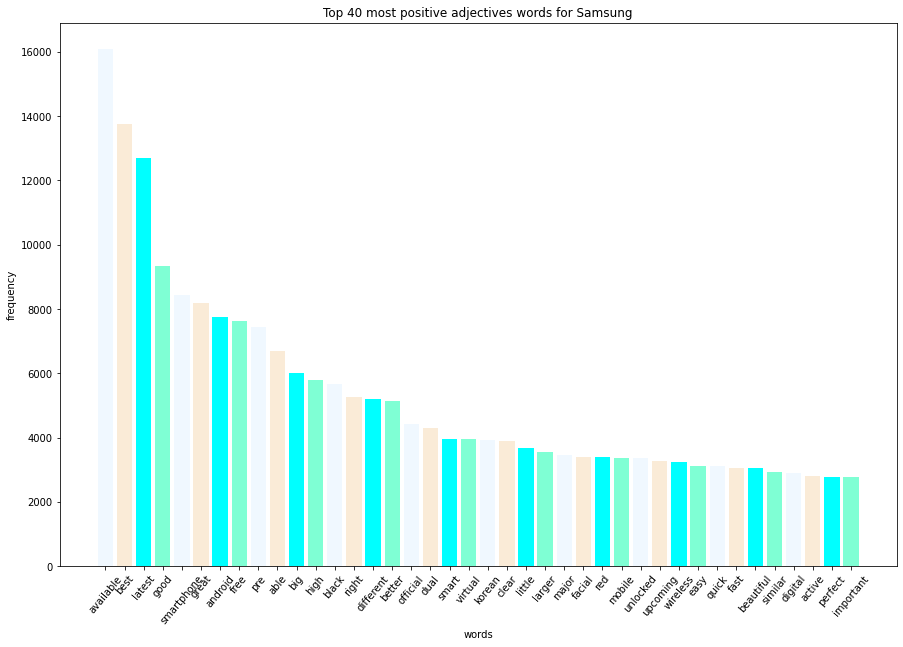

In [33]:
common_s_pos_adj=pd.DataFrame(s_pos_adj_counter.most_common()[:40])
common_s_pos_adj.columns=['word','count']
plt.figure(figsize=(15,10))
color_backup = ['aliceblue','antiquewhite','aqua','aquamarine'] 
plt.bar(common_s_pos_adj['word'],common_s_pos_adj['count'],color=color_backup)
plt.xticks(rotation=50)
plt.xlabel("words")
plt.ylabel("frequency")
plt.title('Top 40 most positive adjectives words for Samsung')
plt.show()

# Sentiment Analysis of Samsung product

In [34]:
apple = data[(data['apple'] == 1) & (data['samsung'] != 1)]

In [35]:
apple.loc[:,'Sound Bite Text'] = apple.loc[:,'Sound Bite Text'].apply(delete_URL).copy()
apple.loc[:,'Sound Bite Text'] = apple.loc[:,'Sound Bite Text'].apply(remove_stop_words).copy()

/Users/jingyiran/opt/anaconda3/envs/yiyi/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


### TextBlob

In [36]:
# texblob- apple
apple.loc[:,'sentiment score'] = apple.loc[:,'Sound Bite Text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity).copy()
apple.loc[:,"sentiment"] = np.select([apple.loc[:,"sentiment score"] < 0, 
                                      apple.loc[:,"sentiment score"] == 0, apple.loc[:,"sentiment score"] > 0],
                                     ['neg', 'neu', 'pos']).copy()

/Users/jingyiran/opt/anaconda3/envs/yiyi/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


### Generate both positive and negative reviews for further analysis

In [37]:
apple_neg = apple.groupby('sentiment').get_group('neg')
apple_pos = apple.groupby('sentiment').get_group('pos')

In [38]:
neg_apple_tweets = apple_neg['Sound Bite Text']

In [39]:
useless3 = ['smartphone', 'phone', 'mobile', 'phones','smartphones','iphone','iphones','come','said','apple','irrelevant']

# Top Attributes of negative reviews of Apple

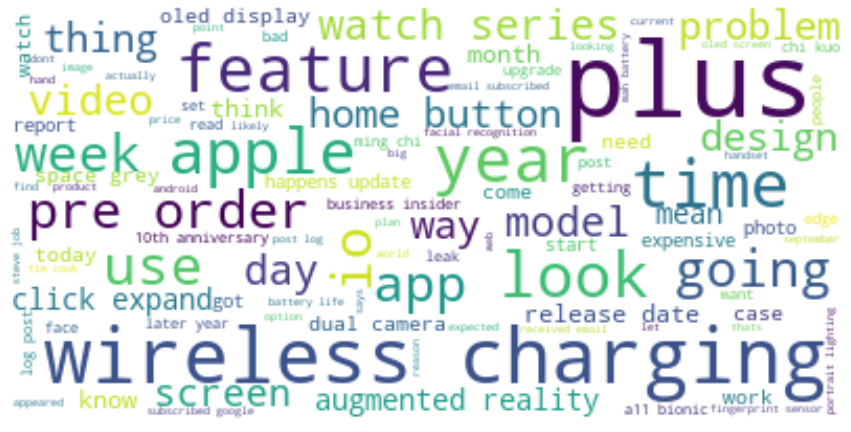

In [40]:
a_neg_str = ''.join(neg_apple_tweets)
cleaned_a_neg=[word for word in tknzr.tokenize(a_neg_str.lower()) if word not in useless3 and len(word)>2]
cleaned_a_neg_str = ' '.join(cleaned_a_neg)  

# Use wordcloud to visualize the words with frequency
wordcloud_s_pos = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(cleaned_a_neg_str)
plt.figure(figsize=(15,12))
plt.imshow(wordcloud_s_pos, interpolation='bilinear')
plt.axis("off")
plt.show()

### Generate Top 40 features

In [41]:
apple_adjs = []
apple_nouns = []
apple_overall = []

apple_adj_counter = Counter(apple_adjs)
apple_noun_counter = Counter(apple_nouns)
apple_overall_counter = Counter(apple_overall)

for tw in neg_apple_tweets:
    for token in nlp(tw.lower()):
        if len(token.text) > 2:
            apple_overall.append(token.text)
        if token.pos_ == 'ADJ' and len(token.text) > 2:
            apple_adjs.append(token.text)
        elif token.pos_ == 'NOUN' and len(token.text) > 2:
            apple_nouns.append(token.text)

In [42]:
apple_adj_counter.update(apple_adjs)
apple_noun_counter.update(apple_nouns)
apple_overall_counter.update(apple_overall)

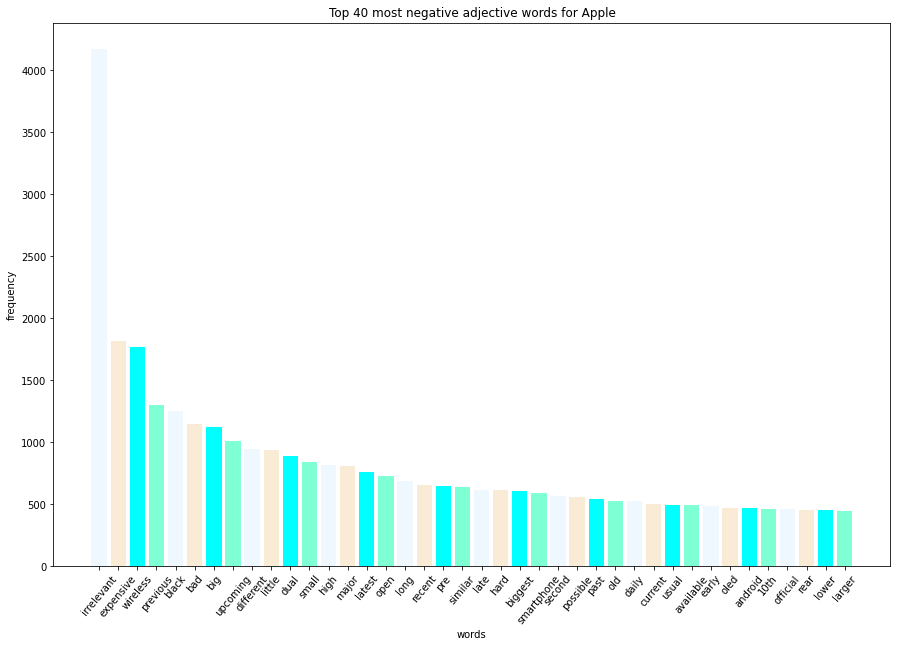

In [43]:
common_a_neg_adj=pd.DataFrame(apple_adj_counter.most_common()[:40])
common_a_neg_adj.columns=['word','count']
plt.figure(figsize=(15,10))
color_backup = ['aliceblue','antiquewhite','aqua','aquamarine'] 
plt.bar(common_a_neg_adj['word'],common_a_neg_adj['count'],color=color_backup)
plt.xticks(rotation=50)
plt.xlabel("words")
plt.ylabel("frequency")
plt.title('Top 40 most negative adjective words for Apple')
plt.show()

# Top Attributes of positive reviews of Apple

In [44]:
pos_apple_tweets = apple_pos['Sound Bite Text']

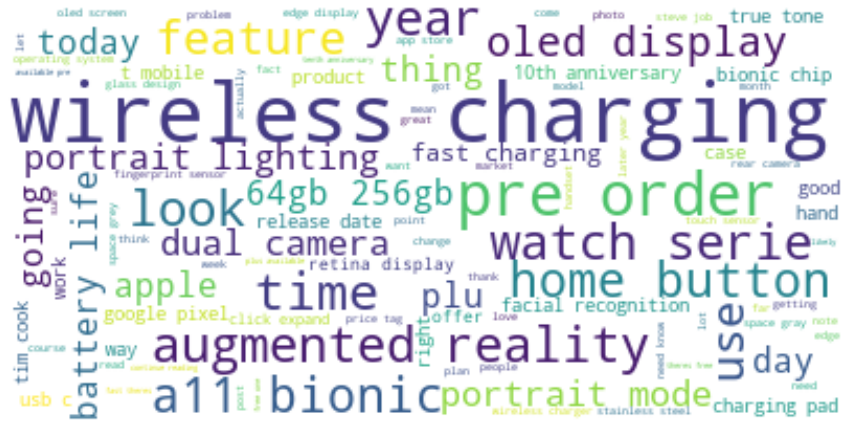

In [45]:
a_pos_str = ''.join(pos_apple_tweets)
cleaned_a_pos=[word for word in tknzr.tokenize(a_pos_str.lower()) if word not in useless3 and len(word)>2]
cleaned_a_pos_str = ' '.join(cleaned_a_pos)  

# Use wordcloud to visualize the words with frequency
wordcloud_s_pos = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(cleaned_a_pos_str)
plt.figure(figsize=(15,12))
plt.imshow(wordcloud_s_pos, interpolation='bilinear')
plt.axis("off")
plt.show()

### Generate top 40 attributes

In [46]:
apple_pos_adjs = []
apple_pos_nouns = []
apple_pos_overall = []

apple_adj_pos_counter = Counter(apple_pos_adjs)
apple_noun_pos_counter = Counter(apple_pos_nouns)
apple_overall_pos_counter = Counter(apple_pos_overall)

for tw in pos_apple_tweets:
    for token in nlp(tw.lower()):
        if len(token.text) > 2:
            apple_pos_overall.append(token.text)
        if token.pos_ == 'ADJ' and len(token.text) > 2:
            apple_pos_adjs.append(token.text)
        elif token.pos_ == 'NOUN' and len(token.text) > 2:
            apple_pos_nouns.append(token.text)

In [47]:
apple_adj_pos_counter.update(apple_pos_adjs)
apple_noun_pos_counter.update(apple_pos_nouns)
apple_overall_pos_counter.update(apple_pos_overall)

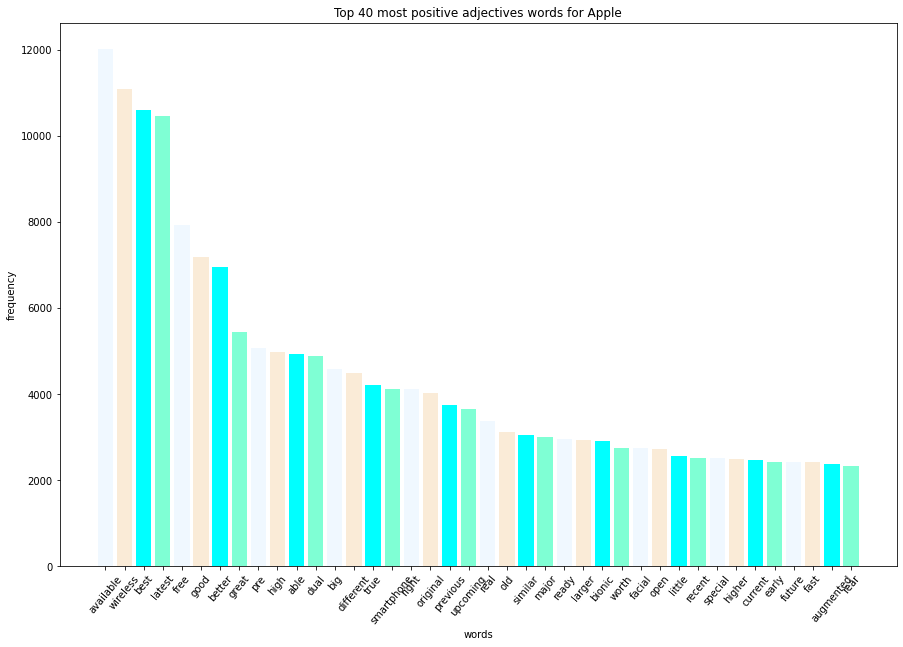

In [48]:
common_a_pos_adj=pd.DataFrame(apple_adj_pos_counter.most_common()[:40])
common_a_pos_adj.columns=['word','count']
plt.figure(figsize=(15,10))
color_backup = ['aliceblue','antiquewhite','aqua','aquamarine'] 
plt.bar(common_a_pos_adj['word'],common_a_pos_adj['count'],color=color_backup)
plt.xticks(rotation=50)
plt.xlabel("words")
plt.ylabel("frequency")
plt.title('Top 40 most positive adjectives words for Apple')
plt.show()